In [1]:
# import xarray as xr
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
def math_wind(speed, direc):
    md = 270-direc
    md = np.array(np.where(md>0,md,md+360))

    u = np.array([speed[i] * math.cos(math.radians(md[i])) for i in range(len(md))])
    v = np.array([speed[i] * math.sin(math.radians(md[i])) for i in range(len(md))])

    return u, v #remember that u is EW and v is NS

def calc_stats(x, y):
    stats = {}
    MSE = np.mean((y - x)**2)
    stats['RMSE'] = np.sqrt(MSE)
    stats['bias'] = np.mean(y) - np.mean(x)
    stats['WSS'] = 1 - MSE / np.mean((abs(y - np.mean(x)) + abs(x - np.mean(x)))**2)
    
    return stats

def plot_panel(ax, x, y, lims, units):
    stats = calc_stats(x, y)

    statstext = f"RMSE = {stats['RMSE']:.3f} {units}\nbias = {stats['bias']:.3f} {units}\nWSS = {stats['WSS']:.3f}"
    
    props = dict(boxstyle='round', facecolor='w', alpha=0.9)
    c = ax.text(0.5, 0.04, statstext, bbox=props, transform=ax.transAxes, fontsize=9)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    return c

# first working with current and temperature mooring in barkley canyon
also has oxygen and salinity at a nearby meering if of interest for a timeseries later

In [3]:
df = pd.read_pickle('/data1/bbeutel/LO_output/extract_cast/onc/scalar_1196714.p')

In [4]:
df['u'], df['v'] = math_wind(df['current_speed_calculated (m s-1)'], df['current_direction_calculated (degree)'])
df.head()

,time (UTC),current_speed_calculated (m s-1),current_direction_calculated (degree),Temperature (K),latitude (degrees_north),longitude (degrees_east),depth (m),model_u,model_v,model_t,u,v
0,2017-06-15 04:40:00+00:00,0.104087,294.794648,280.34,48.3332,-125.875583,415.0,-0.026051,0.082908,278.724369,0.094491,-0.043650
1,2017-06-15 05:00:00+00:00,0.117712,296.291258,279.20,48.3332,-125.875583,415.0,0.000725,0.064490,278.695665,0.105535,-0.052138
2,2017-06-15 05:20:00+00:00,0.077795,304.477991,279.04,48.3332,-125.875583,415.0,0.000725,0.064490,278.695665,0.064129,-0.044039
3,2017-06-15 05:40:00+00:00,0.060465,320.724553,279.03,48.3332,-125.875583,415.0,0.000725,0.064490,278.695665,0.038277,-0.046807
4,2017-06-15 06:00:00+00:00,0.023431,326.314422,279.05,48.3332,-125.875583,415.0,0.009222,0.018485,278.654139,0.012996,-0.019497


In [5]:
# now that's a bit to much to plot, do average by day
davg = df.set_index('time (UTC)')
davg = davg.resample('D',axis=0).mean()

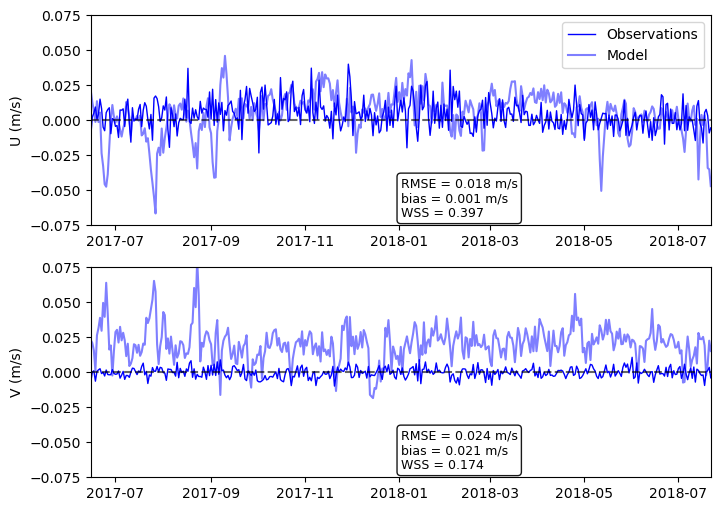

In [6]:
fig,ax = plt.subplots(2,1,figsize=(8,6))

ax[0].plot(davg.index, davg['u'],'b',lw=1,label='Observations')
ax[0].plot(davg.index, davg['model_u'],'b',label='Model',alpha=0.5)
ax[0].set_ylabel('U (m/s)')
ax[0].legend()
# plot the stats pannel
plot_panel(ax[0], davg['u'], davg['model_u'], (-0.1,0.1), 'm/s')

ax[1].plot(davg.index, davg['v'],'b',lw=1,label='Observations')
ax[1].plot(davg.index, davg['model_v'],'b',label='Model',alpha=0.5)
ax[1].set_ylabel('V (m/s)')
# plot the stats pannel
plot_panel(ax[1], davg['v'], davg['model_v'], (-0.1,0.1), 'm/s')

for i in range(len(ax)):
    ax[i].set_ylim([-0.075,0.075])
    ax[i].set_xlim([np.min(davg.index),np.max(davg.index)])
    ax[i].plot([np.min(davg.index),np.max(davg.index)],[0,0],'k--',alpha=0.6)


(17332.0, 17734.0)

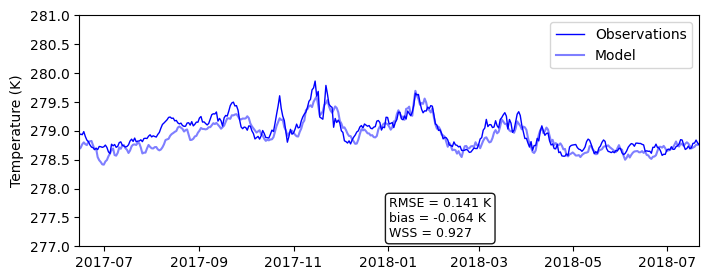

In [10]:
# what about temperature?
fig,ax = plt.subplots(1,1,figsize=(8,3))

ax.plot(davg.index, davg['Temperature (K)'],'b',lw=1,label='Observations')
ax.plot(davg.index, davg['model_t'],'b',label='Model',alpha=0.5)
ax.set_ylabel('Temperature (K)')
ax.legend()
# plot the stats pannel
plot_panel(ax, davg['Temperature (K)'], davg['model_t'], (277,281), 'K')
ax.set_xlim([np.min(davg.index),np.max(davg.index)])